# Testing package `Whirl2d` on Navier-Stokes solution in open domain

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a basic domain with no body

In [2]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 0


#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [3]:
Δx = 0.04
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 0
Grid: number of cells = (100,50), Δx = 0.04, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [4]:
Re = 200
physparams = NavierStokes.set_freestream([0.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,0.5*Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([0.0, 0.0], 200.0), 0.0625)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables and defines the operators needed for calling the IF-RK

In [5]:
@time gops, ops = NavierStokes.set_operators!(dom,params);

  1.129282 seconds (831.52 k allocations: 116.651 MiB, 2.68% gc time)


### Create an initial solution structure

In [6]:
s = NavierStokes.Soln(dom)

Solution: t = 0.0


### Set initial condition

The circulation is set to $\pi \sigma^2$

In [9]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)
σ = 0.2
wexact(t) = [exp(-((x[i]-0*t)^2+y[j]^2)/(σ^2+4t/Re))/(1+4t/(Re*σ^2)) for i = 1:length(x), j = 1:length(y)];
s.u[dom.grid.cellint[1],dom.grid.cellint[2]] = dom.grid.Δx*wexact(0.0);
ψ = -gops.L⁻¹(s.u);

### Advance the solution

In [11]:
@time for i = 1:75
    s = TimeMarching.ifrk!(s,tparams,ops)
end
s

  0.854672 seconds (36.98 k allocations: 353.184 MiB, 4.24% gc time)


Solution: t = 3.000000000000002


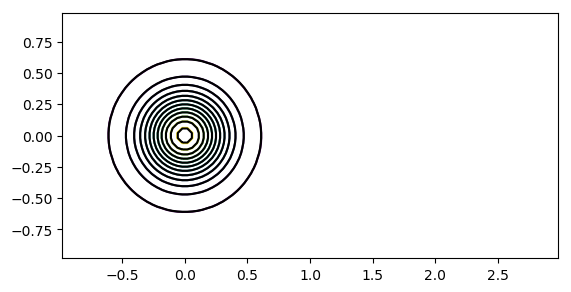

(-0.98, 2.98, -0.98, 0.98)

In [12]:
contour(x,y,transpose(s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx),linspace(0.01,1,30))
contour(x,y,transpose(wexact(s.t)),linspace(0.01,1,30),colors="black")
axis("scaled")

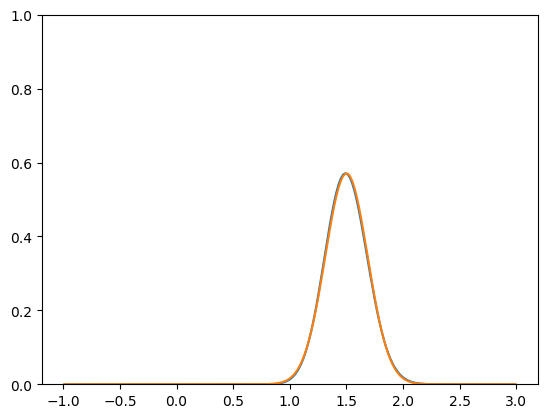

(0.0, 1.0)

In [14]:
plot(x,s.u[2:end-1,51]/Δx)
plot(x,wexact(s.t)[:,51])
ylim(0.0,1.0)

In [13]:
ψ = -gops.L⁻¹(s.u);
u,v = Grids.curl(dom.grid,ψ)
gradu = Grids.grad(dom.grid,u,v);

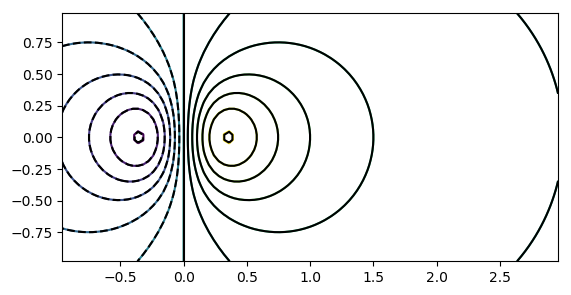

(-0.96, 2.96, -0.98, 0.98)

In [17]:
x = Grids.xfacey(dom.grid)
y = Grids.yfacey(dom.grid)
uexact(t) = [-y[j]*σ^2/(2*((x[i]-0*t)^2+y[j]^2))*(1-exp(-((x[i]-0*t)^2+y[j]^2)/(σ^2+4t/Re))) for i = 1:length(x), j = 1:length(y)];
vexact(t) = [x[i]*σ^2/(2*((x[i]-0*t)^2+y[j]^2))*(1-exp(-((x[i]-0*t)^2+y[j]^2)/(σ^2+4t/Re))) for i = 1:length(x), j = 1:length(y)];
contour(x,y,transpose(v[dom.grid.faceyint[1],dom.grid.faceyint[2]]),linspace(-0.1,0.1,31))
contour(x,y,transpose(vexact(s.t)),linspace(-0.1,0.1,31),colors="black")
axis("scaled")

In [18]:
err = norm(v[dom.grid.faceyint[1],dom.grid.faceyint[2]]-vexact(s.t))/norm(vexact(s.t))

0.0014117127974867408

In [198]:
push!(dxarray,Δx)
push!(errarray,err)

5-element Array{Float64,1}:
 9.75052e-5 
 0.000390141
 0.00156986 
 0.00639575 
 0.0101175  

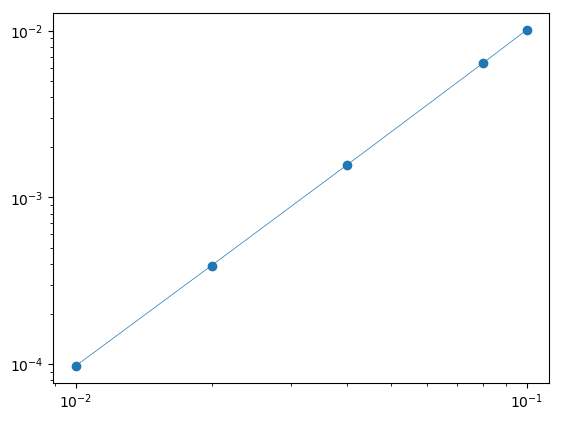

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x140ad3a90>

In [199]:
loglog(dxarray,errarray,linewidth=0.5,marker="o")

In [106]:
size(v[2:end-1,51])
#size(x)

(199,)

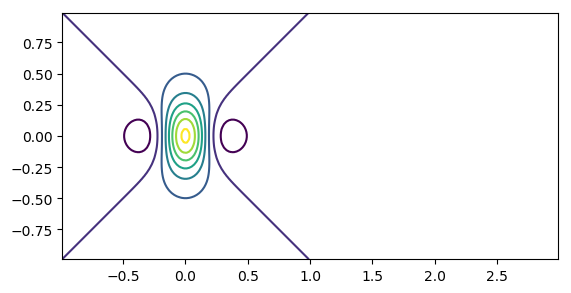

(-0.99, 2.99, -0.99, 0.99)

In [41]:
contour(x,y,transpose(gradu[1,2][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx))
axis("scaled")

In [38]:
size(gradu[1,1])

(201, 101)